In [22]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from random import randint
import cv2
import csv
import json
from json import JSONEncoder


In [23]:
path = '/home/yauheni/source/repos/jubilant-funicular/lab1/discuss.png'
data = cv2.imread(path)


In [24]:
def m_dot(X, Y):
    # if X.shape[1] != Y.shape[0]:
    #     return None
    return [[sum(a * b for a, b in zip(X_ROW, Y_COL)) for Y_COL in zip(*Y)] for X_ROW in X]


def m_t(M):
    return [[M[j][i] for j in range(len(M))] for i in range(len(M[0]))]


In [25]:

def get_shape(path):
    img_matrix = cv2.imread(path)
    return img_matrix.shape, img_matrix.reshape(-1).shape[0]


def get_blocks_params(horizontal_compression, vertical_compression, img_size):
    h_blocks_num = img_size // horizontal_compression
    v_blocks_num = img_size // vertical_compression
    return h_blocks_num, v_blocks_num, h_blocks_num * v_blocks_num


def normalize_data(data):
    return np.asarray(data) / 255

In [26]:
class NumpyArrayEncoder(JSONEncoder):
  def default(self, obj):
    if isinstance(obj, np.ndarray):
      return obj.tolist()
    return JSONEncoder.default(self, obj)

In [27]:
n, m, size = int(input()), int(input()), get_shape(path)[0][1]
vertical, horizontal, blocks_num = get_blocks_params(n, m, size)


In [28]:
images_num = 2000

data = np.zeros((blocks_num * images_num, n*m*3))
pic = normalize_data(cv2.imread(path))

for img_i in range(images_num):
    for v_i in range(vertical):
        for h_i in range(horizontal):
            data[blocks_num * img_i + horizontal * v_i + h_i, :] = pic[m * v_i: m * (v_i + 1), n * h_i: n *
                                                                       (h_i + 1), :].reshape(n*m*3) * 2 - 1


In [29]:
class NeuralNetwork():
    def __init__(self, n: int = 16, m: int = 16, alpha: float = 5*10e-5) -> None:
        self.alpha = alpha
        self.W1 = np.random.normal(0.0, pow(m*n, -0.5), (3*m*n, m*n))
        self.W2 = np.random.normal(0.0, pow(m*n, -0.5), (3*m*n, m*n))

    def compress(self, X):
        splitted_pic = []
        for j in range(vertical):
            for k in range(horizontal):
                splitted_pic.append(
                    X[m*j:m*(j+1), n*k:n*(k+1), :].reshape(n*m*3)*2-1)

        encoded_pic = []
        for i in splitted_pic:
            encoded_pic.append(i@self.W1)

        return np.array(encoded_pic)

    def decompress(self, X):
        pic = np.zeros((size, size, 3))
        for i in range(vertical):
            for j in range(horizontal):
                pic[i*m:(i+1)*m, j*n:(j+1)*n] = (X[i*m+j]
                                                 @ self.W2).reshape(16, 16, 3)
        pic = (pic+1)/2
        return pic

    def back_propagation(self, X):
        compressed = (X@self.W1)[np.newaxis]
        output = np.dot(compressed, self.W2)
        error = (output - X)
        self.W2 -= self.alpha*np.dot(compressed.T, error)
        X = X[np.newaxis]
        self.W1 -= self.alpha*np.dot(np.dot(X.T, error), self.W2.T)
        return np.abs(error).sum()

    def save(self):
        # with open("w1.csv", "+w") as data:
        #     writer = csv.writer(data, delimiter=',')
        #     writer.writerows(self.W1)
        w1_data = { "array": self.W1 }
        w2_data = { "array": self.W2 }
        
        encoded_w1 = json.dumps(w1_data, cls=NumpyArrayEncoder)
        encoded_w2 = json.dumps(w2_data, cls=NumpyArrayEncoder)
        
        with open("w1.json", "w") as output:
            output.write(encoded_w1)
            
        with open("w2.json", "w") as output:
            output.write(encoded_w2)
        

    def load(self):
        with open('w1.json', 'r') as input:
            json_obj = json.load(input)
            self.W1 = np.asarray(json_obj["array"])
        
        with open('w2.json', 'r') as input:
            json_obj = json.load(input)
            self.W2 = np.asarray(json_obj["array"])


In [30]:
nn = NeuralNetwork()

print('Load previous weights?(y/n)')
res = str(input())
if res == 'y':
    nn.load()
else:
    number_of_trainings = 100
    train = data[:number_of_trainings]
    errors = []
    counter = 0
    for image in train:
        errors.append(nn.back_propagation(image))


Load previous weights?(y/n)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Save current weights?(y/n)


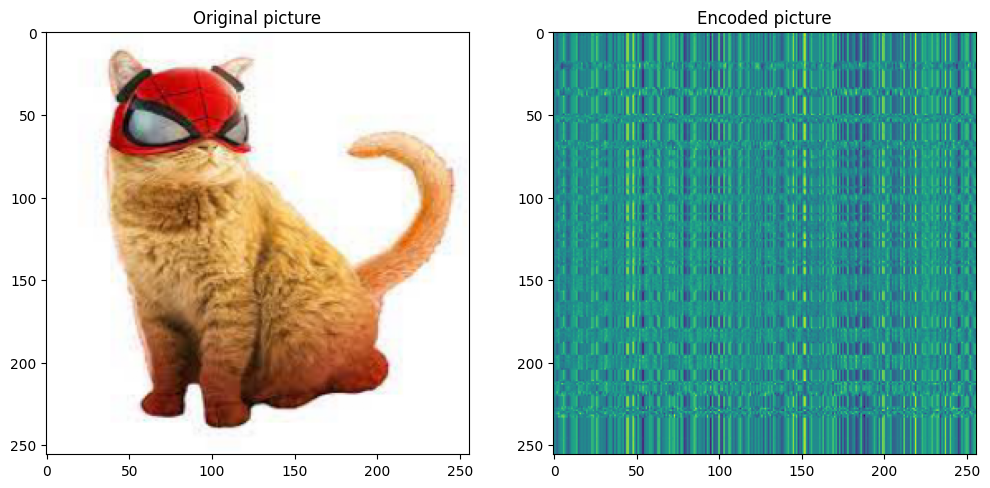

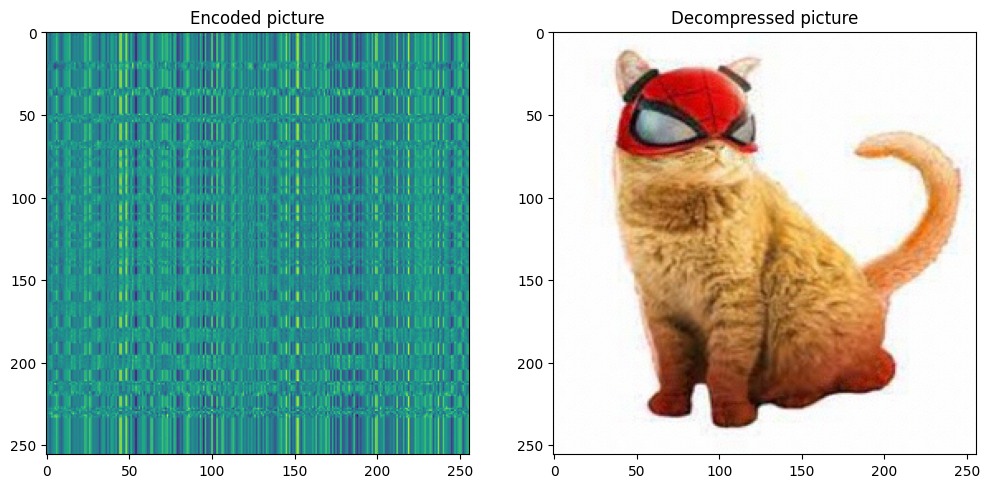

In [31]:
matplotlib.rcParams['figure.figsize'] = [12, 12]

pic = mpimg.imread(
    '/home/yauheni/source/repos/jubilant-funicular/lab1/discuss.png')
compressed_pic = nn.compress(pic)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(pic)
axs[1].imshow(compressed_pic)
axs[0].set_title("Original picture")
axs[1].set_title("Encoded picture")

decompressed_pic = nn.decompress(compressed_pic)

fig1, axs1 = plt.subplots(1, 2)

axs1[0].imshow(compressed_pic)
axs1[1].imshow(decompressed_pic)
axs1[0].set_title("Encoded picture")
axs1[1].set_title("Decompressed picture")


print('Save current weights?(y/n)')
sv = str(input())
if sv == 'y':
    nn.save()
